<font color='red'>QUABOUL Dorian - 3872944</font><br>
<font color='red'>IKHLEF MOUHAMAD - 3870476</font>

# Traitement Automatique de la Langue

## Tâche 1 : détection d'auteur, Chirac/Miterrand

_Import de librairies_

In [1]:
import codecs
import re
import string
from wordcloud import WordCloud
import time
import unicodedata
import numpy as np

import spacy
nlp = spacy.load("fr_core_news_sm")

import sklearn
import sklearn.naive_bayes as bayes
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import svm, linear_model as lin
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.snowball import FrenchStemmer

_Liens utiles_

##### Chargement des données
- http://www-connex.lip6.fr/~guigue/wikihomepage/pmwiki.php?n=Course.CourseTALTME3bow

##### Nettoyage, analyse des données textuelles
- https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4854971-nettoyez-et-normalisez-les-donnees
    
    

### Lectures des données utilisées

In [2]:
def read_file(fn):
    with codecs.open(fn,encoding="utf-8") as f:
        return f.read()

In [3]:
def compteLignes(fname):
    count = 0
    with open(fname, 'r') as f:
        for line in f:
            count += 1
    return count

In [4]:
def extract_labels_txt(fname,n_lines):
    
    corpus = codecs.open(fname,"r",encoding="utf-8")
    
    alltxts = []
    labels = np.ones(n_lines) * (-1)
    
    for i in range(n_lines):
        
        line = corpus.readline()
 
        label = re.search(r"<[0-9]*:[0-9]*:(.)>.*",line).group(1)
        txt = re.search(r"<[0-9]*:[0-9]*:.>(.*)",line).group(1)

        if label == 'M':
            labels[i] = 1

        alltxts.append(txt)
        
    corpus.close()
    
    return labels,alltxts

def extract_txt(fname,n_lines):
    
    corpus = codecs.open(fname,"r",encoding="utf-8")
    
    alltxts = []
    
    for i in range(n_lines):
        line = corpus.readline()
        
        txt = re.search(r"<[0-9]*:[0-9]*>(.*)",line).group(1)

        alltxts.append(txt)
    
    corpus.close()
    
    return alltxts

In [5]:
fname_train = "data/corpus.tache1.learn.utf8"
fname_test = "data/corpus.tache1.test.utf8"

In [6]:
n_train = compteLignes(fname_train)
n_test = compteLignes(fname_test)
print("Nombre de lignes pour le corpus de train = %d"%n_train)
print("Nombre de lignes pour le corpus de test = %d"%n_test)

Nombre de lignes pour le corpus de train = 57413
Nombre de lignes pour le corpus de test = 27162


In [7]:
labels_train, corpus_train = extract_labels_txt(fname_train,n_train)
corpus_test = extract_txt(fname_test,n_test)

print("Nombre de M = ",np.sum(np.where(labels_train == 1,1,0)))
print("Nombre de C = ",np.sum(np.where(labels_train == -1,1,0)))

Nombre de M =  7523
Nombre de C =  49890


### NLP Preprocessing

In [8]:
txt = corpus_train[500]
print(txt)
print("-----")
print("NOMBRE DE TOKENS = ",len(txt.split()))

 Elle s'est très sérieusement relevée et le nombre de chefs d'entreprise, grandes, petites et moyennes, qui m'accompagnent, est un témoignage.
-----
NOMBRE DE TOKENS =  20


#### [ETAPE 1] Text Normalization/Cleaning

In [9]:
def text_normalization(s):
    # source : http://www-connex.lip6.fr/~guigue/wikihomepage/pmwiki.php?n=Course.CourseTALTME3pp
    
    # elimination tabulations et retours à la ligne
    s = re.sub("\s"," ",re.sub("\s(?=\s)"," ",s))
    # elimination des ponctuations
    punc = string.punctuation
    s = s.translate(str.maketrans(punc, ' ' * len(punc)))
    # elimination des chiffres
    s = re.sub('\d+', '', s)
    # elimination des espaces multiples
    s = re.sub(' +', ' ', s)
    # elimination des espaces au debut et à la fin
    s = s.strip()
    # texte en minuscule
    s = s.lower()

    return s

In [10]:
step_1 = text_normalization(txt)
print(step_1)
print("-----")
print("NOMBRE DE TOKENS = ",len(step_1.split()))

elle s est très sérieusement relevée et le nombre de chefs d entreprise grandes petites et moyennes qui m accompagnent est un témoignage
-----
NOMBRE DE TOKENS =  23


#### POS Tagging

In [11]:
def postagging(s):
    print([w.pos_ for w in nlp(s)])
    print([w.text for w in nlp(s)])

In [12]:
postagging(step_1)

['PRON', 'PRON', 'AUX', 'ADV', 'ADV', 'VERB', 'CCONJ', 'DET', 'NOUN', 'ADP', 'NOUN', 'NOUN', 'NOUN', 'ADJ', 'ADJ', 'CCONJ', 'NOUN', 'PRON', 'NOUN', 'VERB', 'AUX', 'DET', 'NOUN']
['elle', 's', 'est', 'très', 'sérieusement', 'relevée', 'et', 'le', 'nombre', 'de', 'chefs', 'd', 'entreprise', 'grandes', 'petites', 'et', 'moyennes', 'qui', 'm', 'accompagnent', 'est', 'un', 'témoignage']


#### [ETAPE 2] Suppresion des Stopwords

In [13]:
def delete_stopwords(s,stopwords) :
    tokens = nlp(s)
    return " ".join([w.text for w in tokens if w.text not in stopwords])

In [14]:
stopwords_fr = read_file("data/stopwords_french.txt").split("\r\n")
print("Liste des "+str(len(stopwords_fr))+" stopwords français :\n",stopwords_fr)

Liste des 691 stopwords français :
 ['a', 'abord', 'absolument', 'afin', 'ah', 'ai', 'aie', 'aient', 'aies', 'ailleurs', 'ainsi', 'ait', 'allaient', 'allo', 'allons', 'allô', 'alors', 'anterieur', 'anterieure', 'anterieures', 'apres', 'après', 'as', 'assez', 'attendu', 'au', 'aucun', 'aucune', 'aucuns', 'aujourd', "aujourd'hui", 'aupres', 'auquel', 'aura', 'aurai', 'auraient', 'aurais', 'aurait', 'auras', 'aurez', 'auriez', 'aurions', 'aurons', 'auront', 'aussi', 'autant', 'autre', 'autrefois', 'autrement', 'autres', 'autrui', 'aux', 'auxquelles', 'auxquels', 'avaient', 'avais', 'avait', 'avant', 'avec', 'avez', 'aviez', 'avions', 'avoir', 'avons', 'ayant', 'ayez', 'ayons', 'b', 'bah', 'bas', 'basee', 'bat', 'beau', 'beaucoup', 'bien', 'bigre', 'bon', 'boum', 'bravo', 'brrr', 'c', 'car', 'ce', 'ceci', 'cela', 'celle', 'celle-ci', 'celle-là', 'celles', 'celles-ci', 'celles-là', 'celui', 'celui-ci', 'celui-là', 'celà', 'cent', 'cependant', 'certain', 'certaine', 'certaines', 'certains', 

In [15]:
step_2 = delete_stopwords(step_1, stopwords_fr)
print(step_2)
print("-----")
print("NOMBRE DE TOKENS = ",len(step_2.split()))

sérieusement relevée nombre chefs entreprise grandes petites moyennes accompagnent témoignage
-----
NOMBRE DE TOKENS =  10


#### [ETAPE 3] Stemmatisation

In [16]:
def stemmatisation(s) :
    stemmer = FrenchStemmer()
    words = []
    
    for w in s.split(" ") :
        if w != "" :
            words.append(stemmer.stem(w))
    
    new_s = ' '.join(words)

    return new_s

In [17]:
step_3 = stemmatisation(step_2)
print(step_3)
print("-----")
print("NOMBRE DE TOKENS = ",len(step_3.split()))

sérieux relev nombr chef entrepris grand petit moyen accompagnent témoignag
-----
NOMBRE DE TOKENS =  10


#### Pipeline du preprocessing

In [18]:
def preprocessing(s, option1, stopwords):
    if option1 == "stema" :
        if stopwords :
            return stemmatisation(delete_stopwords(text_normalization(s),stopwords))
        else :
            return stemmatisation(text_normalization(s))
    else :
        if stopwords :
            return delete_stopwords(text_normalization(s),stopwords)
        else :
            return text_normalization(s)

### Exploration et analyse de la matrice Document-Term

#### Construction des différents corpus

In [19]:
# On garde les stopwords
corpus_ = [preprocessing(d,"none",None) for d in corpus_train]
corpus_stema = [preprocessing(d,"stema",None) for d in corpus_train]
# On supprime les stopwords
corpus_sw = [preprocessing(d,"none",stopwords_fr) for d in corpus_train]
corpus_sw_stema = [preprocessing(d,"stema",stopwords_fr) for d in corpus_train]

all_corpus = [[corpus_, corpus_stema],
              [corpus_sw, corpus_sw_stema]]

#### [ETAPE 4] CountVectorizer

![Représentation en une matrice sparse](img/sparse_matrix_corpus.png)

In [20]:
vectorizer = CountVectorizer(max_df=0.85, min_df=0.0001)
X = vectorizer.fit_transform(corpus_sw_stema)

In [21]:
vocab = np.array(vectorizer.get_feature_names())

print("Nombre de mots dans le vocabulaire : ", len(vocab))
print("30 mots du vocabulaire : ", vocab[3000:3030])

Nombre de mots dans le vocabulaire :  5176
30 mots du vocabulaire :  ['mutual' 'mutuel' 'my' 'myster' 'mystéri' 'myth' 'mènent' 'mécan' 'mécen'
 'méconnaiss' 'méconnaîtr' 'méconnu' 'mécénat' 'médaill' 'médecin' 'médi'
 'médiat' 'médiateur' 'médic' 'médical' 'médit' 'méditerran'
 'méditerranéen' 'méfianc' 'mélancol' 'mélang' 'mémoir' 'mémorandum'
 'mémorial' 'ménag']


Text(0.5, 1.0, 'les 20 mots les moins fréquents')

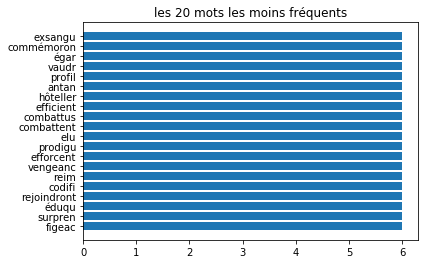

In [22]:
tf = X.toarray().sum(0)
n = 20
ind = tf.argsort()[:n]
plt.barh(vocab[ind], tf[ind])
plt.title("les "+str(n)+" mots les moins fréquents")

Text(0.5, 1.0, 'les 20 mots les plus fréquents')

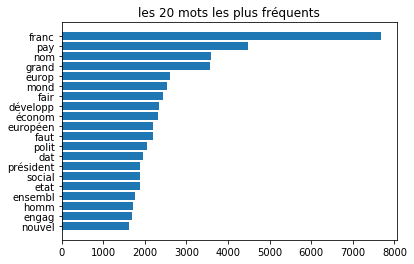

In [23]:
ind = tf.argsort()[-n:]
plt.barh(vocab[ind], tf[ind])
plt.title("les "+str(n)+" mots les plus fréquents")

**WordCloud : Les 10 mots les plus utilisés par président**

In [24]:
def generate_wordcloud(words, president) : 
    
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',  
                min_font_size = 10).generate(words) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.title("Les 15 mots les plus utilisés par "+president)
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

In [25]:
ind_C = np.where(labels_train == -1)
ind_M = np.where(labels_train == 1)

tf_C = X.toarray()[ind_C][:].sum(0)
tf_M = X.toarray()[ind_M][:].sum(0)

ind_mots_C = tf_C.argsort()[-15:]
ind_mots_M = tf_M.argsort()[-15:]

mots_C = vocab[ind_mots_C]
mots_M = vocab[ind_mots_M]

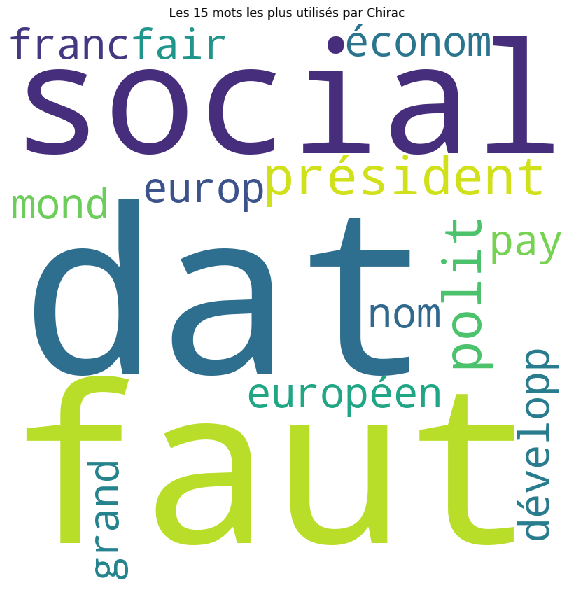

In [26]:
generate_wordcloud(" ".join(mots_C), "Chirac")

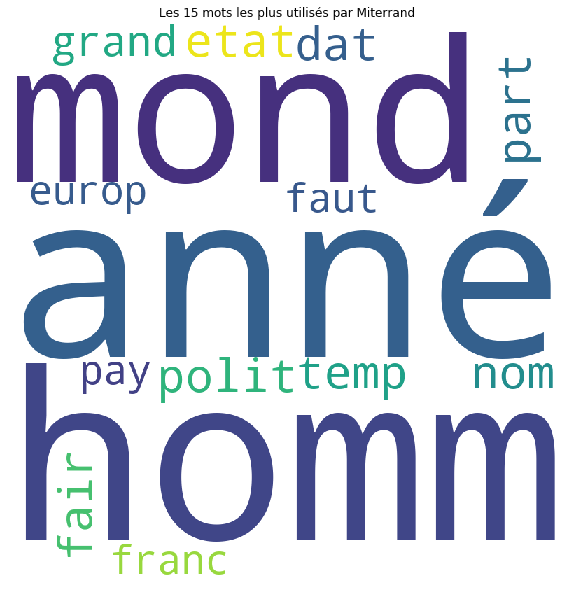

In [27]:
generate_wordcloud(" ".join(mots_M),"Miterrand")

### Optimisation des hyper-paramètres des modèles

In [28]:
def findBestHyperParam(name_clf, X_train, y_train,):
    if name_clf == "[reg_logistic]" :
        
        logistic = lin.LogisticRegression()

        param_grid = {'penalty':['l1', 'l2'],
                      'C':[0.1, 1, 10, 100],
                      'solver':['liblinear', 'saga']}

        grid = GridSearchCV(estimator=logistic,
                            param_grid=param_grid,
                            scoring='f1',
                            verbose=1,
                            n_jobs=-1,
                            cv = 5)
        
        grid_result = grid.fit(X_train, y_train)

        print('Best Score: ', grid_result.best_score_)
        print('Best Params: ', grid_result.best_params_)
        
        return grid_result.best_estimator_
    
    elif name_clf == "[bayes]" :
        
        multi_nb = bayes.MultinomialNB()
        
        param_grid = {'alpha': [0,0.1,1,10,100]}
        
        grid = GridSearchCV(estimator=multi_nb,
                            param_grid=param_grid,
                            scoring='f1',
                            verbose=1,
                            n_jobs=-1,
                            cv = 5)
        
        grid_result = grid.fit(X_train, y_train)
        
        print('Best Score: ', grid_result.best_score_)
        print('Best Params: ', grid_result.best_params_)
        
        return grid_result.best_estimator_
        
    elif name_clf == "[svm]" :
        
        svc = svm.SVC()
        
        param_grid = {'C': [0.1,1, 10, 100], 
                      'gamma': [1,0.1,0.01,0.001],
                      'kernel': ['rbf', 'poly', 'sigmoid']}
        
        grid = GridSearchCV(estimator=svc,
                            param_grid=param_grid,
                            scoring='f1',
                            verbose=1,
                            n_jobs=-1,
                            cv = 5)
        
        grid_result = grid.fit(X_train, y_train)
        
        print('Best Score: ', grid_result.best_score_)
        print('Best Params: ', grid_result.best_params_)
        
        return grid_result.best_estimator_
    else :
        print("Le nom du modèle ne comvient pas pour cette fonction !")

In [29]:
best_multinb = findBestHyperParam("[bayes]", X, labels_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Score:  0.45058196207348045
Best Params:  {'alpha': 0.1}


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.0s finished


In [30]:
n_max = 10000
best_svm = findBestHyperParam("[svm]", X[:n_max], labels_train[:n_max])

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  7.2min finished


Best Score:  0.43558903129568727
Best Params:  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


Source (pour le choix du nmax) : https://datascience.stackexchange.com/questions/64958/why-svm-gridsearch-takes-longer-time

In [31]:
best_reg_logistic = findBestHyperParam("[reg_logistic]", X, labels_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  6.8min finished


Best Score:  0.4238807217678418
Best Params:  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


## Campagne d'évaluation et comparaison de 3 modèles de classification

Cette campagne d'évaluation va consister à choisir les meilleurs paramètres des classifieurs.

Les paramètres qui seront modulés :
- avec ou sans Stopwords
- Unigram/Bigram/Trigram
- Stemmatisation

In [32]:
def campagne_evaluation(corpus, labels, stop_words, ngram, classifieur, clf):

    tic = time.perf_counter() 
    
    ordinates = [[] for i in range(8)]
    abscissas = [[] for i in range(8)]
    cpt = 0

    for tab in corpus :
        for c in tab :
            abscissas[cpt] = np.linspace(20, get_len_vocab(c, ngram), 20, dtype = int)
            abscissas[cpt+1] = np.linspace(20, get_len_vocab(c, ngram), 20, dtype = int)
            for step in abscissas[cpt]:
                vectorizer = CountVectorizer(max_features=step, ngram_range=(1,ngram), max_df=0.85, min_df=0.0001)
                tf_idf = TfidfVectorizer(max_features=step, ngram_range=(1,ngram), max_df=0.85, min_df=0.0001)
                X_v = vectorizer.fit_transform(c)
                X_t = tf_idf.fit_transform(c)
                ordinates[cpt].append(cross_validation(clf, X_v, labels))
                ordinates[cpt+1].append(cross_validation(clf, X_t, labels))
            cpt+=2
             
    print("Temps d'éxécution : "+str(round(time.perf_counter()-tic, 2))+" secondes")
    
    labels = ['TF','TFIDF', 
              'TF-STEMA','TFIDF-STEMA',
              'TF-STPW','TFIDF-STPW',
              'TF-STPW-STEMA','TFIDF-STPW-STEMA']
    
    for j in range(8) :
        plt.plot(abscissas[j], ordinates[j], label=labels[j])
        plt.legend()
        
    plt.title(classifieur + " - F1-score en fonction du nb de mots conservés : "+mot_gram(ngram))
    plt.xlabel("Nombre de mots conservés")
    plt.ylabel("F1-score")
    plt.show()
    
    ind = [np.argmax(o) for o in ordinates]
    max_gram = [abscissas[_][ind[_]] for _ in range(8)] 

    for _ in range(8):
        print("Meilleur score <"+str(ordinates[_][ind[_]])+"> pour",labels[_],"avec "+(str(max_gram[_]))+" "+mot_gram(ngram))

    return max_gram

In [33]:
def cross_validation(clf, X, y, n_splits=5):
    scores = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        scores.append(f1_score(y_test,clf.predict(X_test)))
        
    return sum(scores)/n_splits

In [34]:
def get_len_vocab(corpus, ngram):
    vectorizer = CountVectorizer(max_df=0.85, min_df=0.0001, ngram_range = (1,ngram))
    vectorizer.fit_transform(corpus)
    return len(vectorizer.get_feature_names())

In [35]:
def mot_gram(ngram):
    if ngram == 1:
        return "unigrams"
    elif ngram == 2:
        return "bigrams"
    elif ngram == 3:
        return "trigrams"
    else:
        return "ngrams"

#### 1-SVM

<font color='red'>/!\ A NOTER /!\\</font><br><br>
<font color='red'>Nous avons été dans l'impossibilité de lancer une campagne d'évaluation sur le SVM car le temps d'exécution était beaucoup trop long (toute une nuit à tourner, mais rien ne se passait)</font>

UNIGRAM

In [ ]:
svm1 = campagne_evaluation(all_corpus, labels_train, stopwords_fr, 1, "[SVM]",best_svm)

BIGRAM

In [ ]:
svm2 = campagne_evaluation(all_corpus, labels_train, stopwords_fr, 2, "[SVM]", best_svm)

#### 2- Naive Bayes

UNIGRAM

Temps d'éxécution : 183.46 secondes


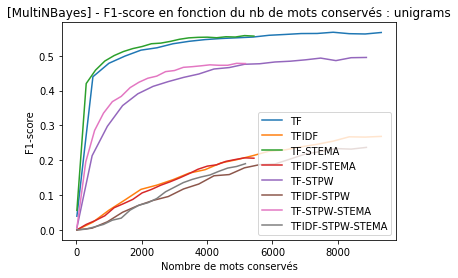

Meilleur score <0.5673904461919742> pour TF avec 7860 unigrams
Meilleur score <0.26841583855046647> pour TFIDF avec 9331 unigrams
Meilleur score <0.5577769552986883> pour TF-STEMA avec 5150 unigrams
Meilleur score <0.2068769504333003> pour TFIDF-STEMA avec 5150 unigrams
Meilleur score <0.49502720260539457> pour TF-STPW avec 8876 unigrams
Meilleur score <0.23687567470482662> pour TFIDF-STPW avec 8876 unigrams
Meilleur score <0.47814342002551263> pour TF-STPW-STEMA avec 4904 unigrams
Meilleur score <0.1900835113755777> pour TFIDF-STPW-STEMA avec 5176 unigrams


In [36]:
bayes1 = campagne_evaluation(all_corpus, labels_train, stopwords_fr, 1, "[MultiNBayes]",best_multinb)

BIGRAM

Temps d'éxécution : 489.52 secondes


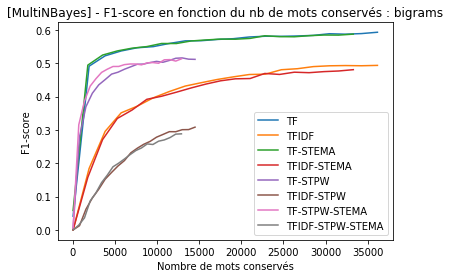

Meilleur score <0.5931445488070791> pour TF avec 36167 bigrams
Meilleur score <0.4936858907964542> pour TFIDF avec 36167 bigrams
Meilleur score <0.5874934854219104> pour TF-STEMA avec 33303 bigrams
Meilleur score <0.48085248624711313> pour TFIDF-STEMA avec 33303 bigrams
Meilleur score <0.5161231874367745> pour TF-STPW avec 12979 bigrams
Meilleur score <0.30837797976321274> pour TFIDF-STPW avec 14504 bigrams
Meilleur score <0.5133846876741472> pour TF-STPW-STEMA avec 12888 bigrams
Meilleur score <0.288317426477814> pour TFIDF-STPW-STEMA avec 12888 bigrams


In [37]:
bayes2 = campagne_evaluation(all_corpus, labels_train, stopwords_fr, 2, "[MultiNBayes]",best_multinb)

#### 3- Régression Logistique

UNIGRAM

Temps d'éxécution : 754.01 secondes


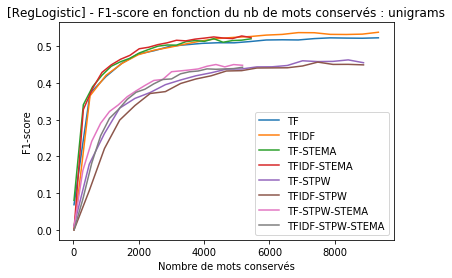

Meilleur score <0.523292122861116> pour TF avec 9331 unigrams
Meilleur score <0.5384471472789066> pour TFIDF avec 9331 unigrams
Meilleur score <0.5209072445645242> pour TF-STEMA avec 4295 unigrams
Meilleur score <0.5283111655053483> pour TFIDF-STEMA avec 5150 unigrams
Meilleur score <0.4631443524399129> pour TF-STPW avec 8409 unigrams
Meilleur score <0.4571140065257449> pour TFIDF-STPW avec 7477 unigrams
Meilleur score <0.4505469804522358> pour TF-STPW-STEMA avec 4361 unigrams
Meilleur score <0.44305540856801795> pour TFIDF-STPW-STEMA avec 5176 unigrams


In [38]:
lin1 = campagne_evaluation(all_corpus, labels_train, stopwords_fr, 1, "[RegLogistic]",best_reg_logistic)

BIGRAM

Temps d'éxécution : 1364.09 secondes


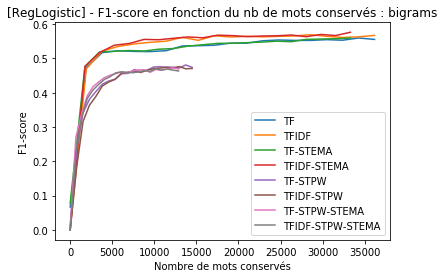

Meilleur score <0.5597163071000875> pour TF avec 34264 bigrams
Meilleur score <0.5693234657773404> pour TFIDF avec 28557 bigrams
Meilleur score <0.5594827784792926> pour TF-STEMA avec 33303 bigrams
Meilleur score <0.5764871990045515> pour TFIDF-STEMA avec 33303 bigrams
Meilleur score <0.481132521645138> pour TF-STPW avec 13741 bigrams
Meilleur score <0.47633350675457875> pour TFIDF-STPW avec 12979 bigrams
Meilleur score <0.47260713902012996> pour TF-STPW-STEMA avec 12210 bigrams
Meilleur score <0.46964830025158> pour TFIDF-STPW-STEMA avec 10178 bigrams


In [39]:
lin2 = campagne_evaluation(all_corpus, labels_train, stopwords_fr, 2, "[RegLogistic]",best_reg_logistic)

Selon la campagne d'évaluation, le meilleur classifieur semble être "Multinomial Naive Bayes". Son temps d'exécution est très court et il a des performances convenables (aux alentours des 0.60 pour le f1-score [classe M]). Nous allons essayer de voir quel serait l'impact avec l'ajout d'un post processing.

### Post Processing 

In [40]:
def post_processing(predictions_letter) :

    predictions_letter_lissag1 = predictions_letter.copy()
    
    for i in range(5, len(predictions_letter)-5):
               
        
        fivebefore = predictions_letter[i-5:i]
        fiveafter = predictions_letter[i+1:i+6]
        
        countM = np.sum(np.where(fivebefore == 'M',1,0))*2.85 + np.sum(np.where(fiveafter == 'M',1,0))*2.85
        countC = np.sum(np.where(fivebefore == 'C',1,0))*1 + np.sum(np.where(fiveafter == 'C',1,0))*1

        if countM > countC :
            predictions_letter_lissag1[i] = 'M'
        elif countM < countC :
            predictions_letter_lissag1[i] = 'C'
        else :
            pass
        
    return predictions_letter_lissag1

In [41]:
test = np.array(["C","C","C","C","M","C","C","M","M","C","C","C","C","C","C","C","C"])
print("Avant lissage")
print(test)
print("Après lissage x 1")
print(post_processing(test))
print("Après lissage x 2")
print(post_processing(post_processing(test)))

Avant lissage
['C' 'C' 'C' 'C' 'M' 'C' 'C' 'M' 'M' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C']
Après lissage x 1
['C' 'C' 'C' 'C' 'M' 'M' 'M' 'C' 'C' 'M' 'C' 'C' 'C' 'C' 'C' 'C' 'C']
Après lissage x 2
['C' 'C' 'C' 'C' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'C' 'C' 'C' 'C' 'C' 'C']


In [42]:
def cross_validation(clf, X, y, n_splits=5):
    scores = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        
        predictions = clf.predict(X_test)
        predictions_letter = np.where(predictions == 1,'M','C')
        
        predictions_post_letter = post_processing(predictions_letter)
        predictions_post = np.where(predictions_post_letter=='M',1,-1)
        
        scores.append(f1_score(y_test,predictions_post))
        
    return sum(scores)/n_splits

In [43]:
def campagne_evaluation(corpus, labels, stop_words, ngram, classifieur, clf):

    tic = time.perf_counter() 
    
    ordinates = [[] for i in range(2)]
    abscissas = [[] for i in range(2)]
    cpt = 0

    for tab in corpus :
        for c in tab :
            abscissas[cpt] = np.linspace(20, get_len_vocab(c, ngram), 20, dtype = int)
            abscissas[cpt+1] = np.linspace(20, get_len_vocab(c, ngram), 20, dtype = int)
            for step in abscissas[cpt]:
                vectorizer = CountVectorizer(max_features=step, ngram_range=(1,ngram), max_df=0.85, min_df=0.0001)
                tf_idf = TfidfVectorizer(max_features=step, ngram_range=(1,ngram), max_df=0.85, min_df=0.0001)
                X_v = vectorizer.fit_transform(c)
                X_t = tf_idf.fit_transform(c)
                ordinates[cpt].append(cross_validation(clf, X_v, labels))
                ordinates[cpt+1].append(cross_validation(clf, X_t, labels))
            cpt+=2
             
    print("Temps d'éxécution : "+str(round(time.perf_counter()-tic, 2))+" secondes")
    
    labels = ['TF','TFIDF']
    
    for j in range(2) :
        plt.plot(abscissas[j], ordinates[j], label=labels[j])
        plt.legend()
        
    plt.title(classifieur + " - F1-score en fonction du nb de mots conservés : "+mot_gram(ngram))
    plt.xlabel("Nombre de mots conservés")
    plt.ylabel("F1-score")
    plt.show()
    
    ind = [np.argmax(o) for o in ordinates]
    max_gram = [abscissas[_][ind[_]] for _ in range(2)] 

    for _ in range(2):
        print("Meilleur score <"+str(ordinates[_][ind[_]])+"> pour",labels[_],"avec "+(str(max_gram[_]))+" "+mot_gram(ngram))

    return max_gram

Temps d'éxécution : 230.98 secondes


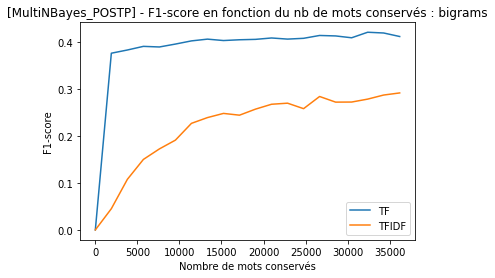

Meilleur score <0.4212460698206299> pour TF avec 32362 bigrams
Meilleur score <0.29191513246723827> pour TFIDF avec 36167 bigrams


In [44]:
bayes2_post = campagne_evaluation([[corpus_]], labels_train, stopwords_fr, 2, "[MultiNBayes_POSTP]",best_multinb)

## Génération des prédictions pour le dataset de test

In [45]:
def generate_file_test(predictions,nom_fichier) :
    predict_letter = np.where(predictions == 1, 'M','C')
    
    filename = nom_fichier+".txt"
    
    with open(filename, "w") as f:
        for i in range(len(predict_letter)) :
            if i == len(predict_letter)-1 :
                f.write("%s" % predict_letter[i]) 
            else:
                f.write("%s\n" % predict_letter[i]) 
            
def generate_file_test2(predict_letter,nom_fichier) :
    filename = nom_fichier+".txt"
    
    with open(filename, "w") as f:
        for i in range(len(predict_letter)) :
            if i == len(predict_letter)-1 :
                f.write("%s" % predict_letter[i]) 
            else:
                f.write("%s\n" % predict_letter[i])           

On transforme le corpus de test en matrice sparse à partir des mots du vocabulaire contenus dans le vectorizer

In [46]:
print(corpus_test[0])
corpus_test_ = [preprocessing(d,"none",None) for d in corpus_test]
print("-----")
print(corpus_test_[0])

 En répondant à votre invitation, en effectuant cette première visite d'Etat d'un Président français en Algérie depuis l'indépendance, j'ai conscience d'ouvrir avec vous un chapitre nouveau de notre histoire commune, le chapitre de la confiance, de l'estime, du respect mutuel, de l'amitié et de la solidarité.
-----
en répondant à votre invitation en effectuant cette première visite d etat d un président français en algérie depuis l indépendance j ai conscience d ouvrir avec vous un chapitre nouveau de notre histoire commune le chapitre de la confiance de l estime du respect mutuel de l amitié et de la solidarité


In [47]:
best_vectorizer = CountVectorizer(max_features=bayes2[0], ngram_range=(1,2), max_df=0.85, min_df=0.0001)
X_train = best_vectorizer.fit_transform(corpus_)

best_multinb.fit(X_train,labels_train)

X_test = best_vectorizer.transform(corpus_test_)
predictions = best_multinb.predict(X_test)
predictions_letter = np.where(predictions == 1,'M','C')

In [49]:
generate_file_test(predictions,"predictions_multinb_tf_bigram")

In [48]:
print("Number of M in predictions :",np.sum(np.where(predictions == 1,1,0)))
print("Number of C in predictions :",np.sum(np.where(predictions == -1,1,0)))

Number of M in predictions : 4603
Number of C in predictions : 22559
